In [49]:
# -*- coding: utf-8 -*-
# Copyright 2017 Interstellar Technologies Inc. All Rights Reserved.

from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from OpenGoddard.optimize import Problem, Guess, Condition, Dynamics


class Rocket:
    GMe = 3.986004418 * 10**14  # Earth gravitational constant [m^3/s^2]
    Re = 6371.0 * 1000  # Earth Radius [m]
    g0 = 9.80665  # Gravitational acceleration on Earth surface [m/s^2]

    def __init__(self):
        self.Vr = np.sqrt(self.GMe / self.Re)  # m/s
        self.H0 = 10.0  # m
        self.V0 = 0.0
        self.M0 = 100000.0  # kg
        self.Mp = self.M0 * 0.99
        self.Cd = 0.6
        self.A = 4.0  # m2
        self.Isp = 300.0  # s
        self.g0 = 9.80665  # m/s2
        self.Tmax = self.M0 * self.g0 * 1.5
        self.MaxQ = 14000.0  # Pa
        self.MaxG = 8.0  # G
        self.Htarget = 300.0 * 1000  # m
        self.Rtarget = self.Re + self.Htarget  # m/s
        self.Vtarget = np.sqrt(self.GMe / self.Rtarget)  # m/s

    def air_density(self, h):
        beta = 1/8500.0  # scale factor [1/m]
        rho0 = 1.225  # kg/m3
        return rho0*np.exp(-beta*h)


def dynamics(prob, obj, section):
    R     = prob.states(0, section)
    theta = prob.states(1, section)
    Vr    = prob.states(2, section)
    Vt    = prob.states(3, section)
    m     = prob.states(4, section)
    Tr    = prob.controls(0, section)
    Tt    = prob.controls(1, section)

    rho = obj.air_density(R - obj.Re)
    Dr = 0.5 * rho * Vr * np.sqrt(Vr**2 + Vt**2) \
        * obj.Cd * obj.A  # [N]
    Dt = 0.5 * rho * Vt * np.sqrt(Vr**2 + Vt**2) \
        * obj.Cd * obj.A  # [N]
    g = obj.g0 * (obj.Re / R)**2  # [m/s2]
    g0 = obj.g0
    Isp = obj.Isp

    dx = Dynamics(prob, section)
    dx[0] = Vr
    dx[1] = Vt / R
    dx[2] = Tr / m - Dr / m - g + Vt**2 / R
    dx[3] = Tt / m - Dt / m - (Vr * Vt) / R
    dx[4] = - np.sqrt(Tr**2 + Tt**2) / g0 / Isp

    return dx()


def equality(prob, obj):
    R     = prob.states_all_section(0)
    theta = prob.states_all_section(1)
    Vr    = prob.states_all_section(2)
    Vt    = prob.states_all_section(3)
    m     = prob.states_all_section(4)
    Tr    = prob.controls_all_section(0)
    Tt    = prob.controls_all_section(1)
    tf    = prob.time_final(-1)

    result = Condition()

    # event condition
    result.add(R[0] - obj.Re, unit=prob.unit_states[0][0])
    result.add(theta[0] - 0.0, unit=prob.unit_states[0][1])
    result.add(Vr[0] - 0.0, unit=prob.unit_states[0][2])
    result.add(Vt[0] - 0.0, unit=prob.unit_states[0][3])
    result.add(m[0] - obj.M0, unit=prob.unit_states[0][4])
    result.add(R[-1] - obj.Rtarget, unit=prob.unit_states[0][1])
    result.add(Vr[-1] - 0.0, unit=prob.unit_states[0][2])
    result.add(Vt[-1] - obj.Vtarget, unit=prob.unit_states[0][3])

    return result()


def inequality(prob, obj):
    R     = prob.states_all_section(0)
    theta = prob.states_all_section(1)
    Vr    = prob.states_all_section(2)
    Vt    = prob.states_all_section(3)
    m     = prob.states_all_section(4)
    Tr    = prob.controls_all_section(0)
    Tt    = prob.controls_all_section(1)
    tf    = prob.time_final(-1)

    rho = obj.air_density(R - obj.Re)
    Dr = 0.5 * rho * Vr * np.sqrt(Vr**2 + Vt**2) \
        * obj.Cd * obj.A  # [N]
    Dt = 0.5 * rho * Vt * np.sqrt(Vr**2 + Vt**2) \
        * obj.Cd * obj.A  # [N]
    g = obj.g0 * (obj.Re / R)**2  # [m/s2]

    # dynamic pressure
    q = 0.5 * rho * (Vr**2 + Vt**2)  # [Pa]
    # accelaration
    a_r = (Tr - Dr) / m
    a_t = (Tt - Dt) / m
    a_mag = np.sqrt(a_r**2 + a_t**2)  # [m/s2]
    # Thrust
    T = np.sqrt(Tr**2 + Tt**2)

    result = Condition()

    # lower bounds
    result.add(R - obj.Re, unit=prob.unit_states[0][0])
    # result.add(Vr - 0.0, unit=prob.unit_states[0][2])
    # result.add(Vt - 0.0, unit=prob.unit_states[0][3])
    result.add(m[1:] - (obj.M0 - obj.Mp), unit=prob.unit_states[0][4])
    result.add(Tr - 0.0, unit=prob.unit_controls[0][0])
    # result.add(Tt + obj.Tmax / obj.unit_T, unit=prob.unit_controls[0][0])
    result.add(Tt - 0.0, unit=prob.unit_controls[0][0])

    # upper bounds
    result.add(obj.M0 - m, unit=prob.unit_states[0][4])
    result.add(obj.Tmax - Tr, unit=prob.unit_controls[0][0])
    result.add(obj.Tmax - Tt, unit=prob.unit_controls[0][0])
    result.add(obj.Tmax - T, unit=prob.unit_controls[0][0])
    # result.add(obj.MaxQ - q, unit = prob.unit_states[0][0])
    result.add(obj.MaxG * obj.g0 - a_mag)

    return result()


def cost(prob, obj):
    m = prob.states_all_section(4)
    # return -m[-1]
    # ==== Caution ====
    # cost function should be near 1.0
    return -m[-1] / prob.unit_states[0][4]


def cost_derivative(prob, obj):
    jac = Condition(prob.number_of_variables)
    index_m0 = prob.index_states(4, 0, 0)
    index_mf = prob.index_states(4, 0, -1)
    m = prob.states_all_section(4)
    # jac.change_value(index_m0, - m[-1] / m[0]**2)
    # jac.change_value(index_mf, - 1.0 / m[0])
    jac.change_value(index_mf, - 1.0)
    return jac()

# ========================
# plt.close("all")
plt.ion()
# Program Starting Point
time_init = [0.0, 800]
n = [30]
num_states = [5]
num_controls = [2]
max_iteration = 20

flag_savefig = False
savefig_file = "08_Rocket_Ascent_Polar/SSTO_"

# ------------------------
# set OpenGoddard class for algorithm determination
prob = Problem(time_init, n, num_states, num_controls, max_iteration)

# ------------------------
# create instance of operating object
obj = Rocket()

unit_R = obj.Re
unit_theta = 1
unit_V = np.sqrt(obj.GMe / obj.Re)
unit_m = obj.M0
unit_t = unit_R / unit_V
unit_T = unit_m * unit_R / unit_t ** 2

prob.set_unit_states_all_section(0, unit_R)
prob.set_unit_states_all_section(1, unit_theta)
prob.set_unit_states_all_section(2, unit_V)
prob.set_unit_states_all_section(3, unit_V)
prob.set_unit_states_all_section(4, unit_m)
prob.set_unit_controls_all_section(0, unit_T)
prob.set_unit_controls_all_section(1, unit_T)
prob.set_unit_time(unit_t)

# ========================
# Initial parameter guess

# altitude profile
R_init = Guess.cubic(prob.time_all_section, obj.Re, 0.0, obj.Rtarget, 0.0)
# Guess.plot(prob.time_all_section, R_init, "Altitude", "time", "Altitude")
# if(flag_savefig):plt.savefig(savefig_file + "guess_alt" + ".png")
# theta
theta_init = Guess.cubic(prob.time_all_section, 0.0, 0.0, np.deg2rad(25.0), 0.0)

# velocity
Vr_init = Guess.linear(prob.time_all_section, 0.0, 0.0)
Vt_init = Guess.linear(prob.time_all_section, 0.0, obj.Vtarget)
# Guess.plot(prob.time_all_section, V_init, "Velocity", "time", "Velocity")

# mass profile
M_init = Guess.cubic(prob.time_all_section, obj.M0, -0.6, obj.M0-obj.Mp, 0.0)
# Guess.plot(prob.time_all_section, M_init, "Mass", "time", "Mass")
# if(flag_savefig):plt.savefig(savefig_file + "guess_mass" + ".png")

# thrust profile
# T_init = Guess.zeros(prob.time_all_section)
Tr_init = Guess.cubic(prob.time_all_section, obj.Tmax/2, 0.0, 0.0, 0.0)
Tt_init = Guess.cubic(prob.time_all_section, obj.Tmax/2, 0.0, 0.0, 0.0)
# Guess.plot(prob.time_all_section, T_init, "Thrust Guess", "time", "Thrust")
# if(flag_savefig):plt.savefig(savefig_file + "guess_thrust" + ".png")

# plt.show()

# ========================
# Substitution initial value to parameter vector to be optimized
# non dimensional values (Divide by scale factor)
prob.set_states_all_section(0, R_init)
prob.set_states_all_section(1, theta_init)
prob.set_states_all_section(2, Vr_init)
prob.set_states_all_section(3, Vt_init)
prob.set_states_all_section(4, M_init)
prob.set_controls_all_section(0, Tr_init)
prob.set_controls_all_section(1, Tt_init)

# ========================
# Main Process
# Assign problem to SQP solver
prob.dynamics = [dynamics]
prob.knot_states_smooth = []
prob.cost = cost
# prob.cost_derivative = cost_derivative
prob.equality = equality
prob.inequality = inequality


def display_func():
    R = prob.states_all_section(0)
    m = prob.states_all_section(4)
    tf = prob.time_final(-1)
    print("m0          : {0:.5f}".format(m[0]))
    print("mf          : {0:.5f}".format(m[-1]))
    print("max altitude: {0:.5f}".format(R[-1]))
    print("final time  : {0:.3f}".format(tf))

prob.solve(obj, display_func, ftol=1e-8)

# ========================
# Post Process
# ------------------------
# Convert parameter vector to variable
R     = prob.states_all_section(0)
theta = prob.states_all_section(1)
Vr    = prob.states_all_section(2)
Vt    = prob.states_all_section(3)
m     = prob.states_all_section(4)
Tr    = prob.controls_all_section(0)
Tt    = prob.controls_all_section(1)
time  = prob.time_update()

# ------------------------
# Calculate necessary variables
rho = obj.air_density(R - obj.Re)
Dr  = 0.5 * rho * Vr * np.sqrt(Vr**2 + Vt**2) \
    * obj.Cd * obj.A  # [N]
Dt  = 0.5 * rho * Vt * np.sqrt(Vr**2 + Vt**2) \
    * obj.Cd * obj.A  # [N]
g   = obj.g0 * (obj.Re / R)**2  # [m/s2]

# dynamic pressure
q   = 0.5 * rho * (Vr**2 + Vt**2)  # [Pa]
# accelaration
a_r = (Tr - Dr) / m
a_t = (Tt - Dt) / m
a_mag = np.sqrt(a_r**2 + a_t**2)  # [m/s2]
# Thrust
T   = np.sqrt(Tr**2 + Tt**2)



---- iteration : 1 ----
Iteration limit exceeded    (Exit mode 9)
            Current function value: -0.04014074281056212
            Iterations: 26
            Function evaluations: 5539
            Gradient evaluations: 26
Iteration limit exceeded
m0          : 100000.00000
mf          : 4014.07428
max altitude: 6671000.00000
final time  : 486.650

---- iteration : 2 ----
Iteration limit exceeded    (Exit mode 9)
            Current function value: -0.042919267327214294
            Iterations: 26
            Function evaluations: 5542
            Gradient evaluations: 26
Iteration limit exceeded
m0          : 100000.00000
mf          : 4291.92673
max altitude: 6671000.00000
final time  : 506.323

---- iteration : 3 ----
Iteration limit exceeded    (Exit mode 9)
            Current function value: -0.043471208657826964
            Iterations: 26
            Function evaluations: 5552
            Gradient evaluations: 26
Iteration limit exceeded
m0          : 100000.00000
mf          

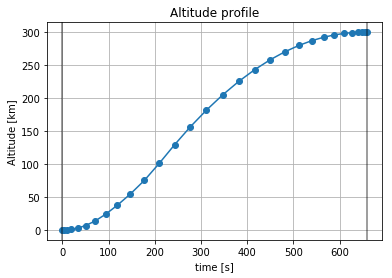

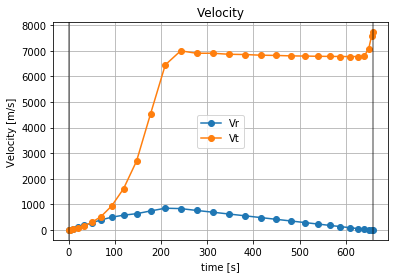

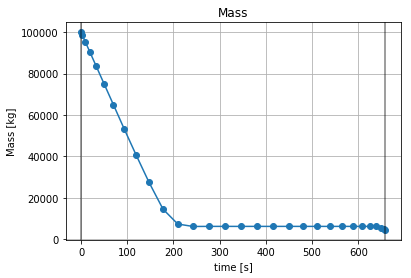

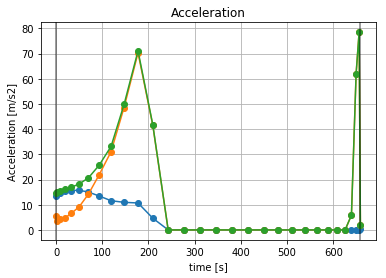

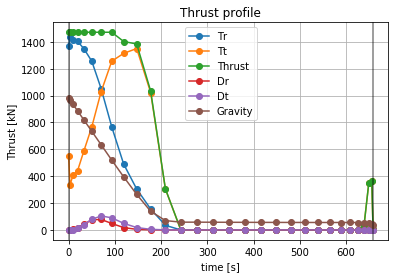

In [50]:
# ------------------------
# Visualizetion
plt.figure()
plt.title("Altitude profile")
plt.plot(time, (R - obj.Re)/1000, marker="o", label="Altitude")
for line in prob.time_knots():
    plt.axvline(line, color="k", alpha=0.5)
plt.grid()
plt.xlabel("time [s]")
plt.ylabel("Altitude [km]")
if(flag_savefig): plt.savefig(savefig_file + "altitude" + ".png")

plt.figure()
plt.title("Velocity")
plt.plot(time, Vr, marker="o", label="Vr")
plt.plot(time, Vt, marker="o", label="Vt")
for line in prob.time_knots():
    plt.axvline(line, color="k", alpha=0.5)
plt.grid()
plt.xlabel("time [s]")
plt.ylabel("Velocity [m/s]")
plt.legend(loc="best")
if(flag_savefig): plt.savefig(savefig_file + "velocity" + ".png")

plt.figure()
plt.title("Mass")
plt.plot(time, m, marker="o", label="Mass")
for line in prob.time_knots():
    plt.axvline(line, color="k", alpha=0.5)
plt.grid()
plt.xlabel("time [s]")
plt.ylabel("Mass [kg]")
if(flag_savefig): plt.savefig(savefig_file + "mass" + ".png")

plt.figure()
plt.title("Acceleration")
plt.plot(time, a_r, marker="o", label="Acc r")
plt.plot(time, a_t, marker="o", label="Acc t")
plt.plot(time, a_mag, marker="o", label="Acc")
for line in prob.time_knots():
    plt.axvline(line, color="k", alpha=0.5)
plt.grid()
plt.xlabel("time [s]")
plt.ylabel("Acceleration [m/s2]")
if(flag_savefig): plt.savefig(savefig_file + "acceleration" + ".png")

plt.figure()
plt.title("Thrust profile")
plt.plot(time, Tr / 1000, marker="o", label="Tr")
plt.plot(time, Tt / 1000, marker="o", label="Tt")
plt.plot(time, T / 1000, marker="o", label="Thrust")
plt.plot(time, Dr / 1000, marker="o", label="Dr")
plt.plot(time, Dt / 1000, marker="o", label="Dt")
plt.plot(time, m * g / 1000, marker="o", label="Gravity")
for line in prob.time_knots():
    plt.axvline(line, color="k", alpha=0.5)
plt.grid()
plt.xlabel("time [s]")
plt.ylabel("Thrust [kN]")
plt.legend(loc="best")
if(flag_savefig): plt.savefig(savefig_file + "force" + ".png")

plt.show()

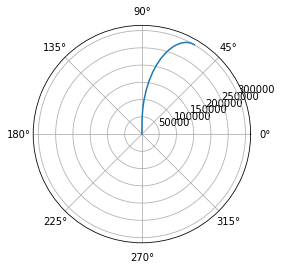

In [51]:
plt.polar(-theta+np.pi/2,R-obj.Re)

In [52]:
m[0]/m[-1]

22.40969743667437

In [53]:
print('Dry Mass Fraction: {}'.format(m[0]/m[-1]))
print('Transfer Time:     {} mins'.format(time[-1]/60))

Dry Mass Fraction: 22.40969743667437
Transfer Time:     10.977634273443421 mins
